Script to test and find velocity threshold for resuspenssion :D

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import useful_params
import mapitas

In [2]:
import statsmodels.api as sm

In [61]:
#td = np.linspace(5, 350, 30)
ssh = np.linspace(-3,3,300)
e3t = np.linspace(5,20,300)
uv_h = np.linspace(1e-3, 1, 300)
z_c = np.log(0.07)
k = 0.42

In [62]:
value = 15 * (1 + (ssh/65))
log_e3t = np.log(value)

In [63]:
td = 65
tau = np.zeros((len(ssh), len(uv_h)))
for j in range(0,len(ssh)):
    tau[:,j] = ((uv_h * k / (log_e3t[j] - z_c)) ** 2) * 1024

In [64]:
SSH, UV_H = np.meshgrid(ssh,uv_h)

In [65]:
ssh_flatten = SSH.flatten()
uv_h_flatten = UV_H.flatten()
tau_flatten = tau.flatten()

In [66]:
DATA_flatten = pd.DataFrame(np.transpose([ssh_flatten, uv_h_flatten]))

In [67]:
x = sm.add_constant(DATA_flatten.values)
modelo = sm.OLS(tau_flatten, x).fit()
prediction_modelo = modelo.predict(x)
rmse = sm.tools.eval_measures.rmse(tau_flatten, prediction_modelo)
meansq = sm.tools.eval_measures.meanabs(tau_flatten, prediction_modelo)
mse = sm.tools.eval_measures.mse(tau_flatten, prediction_modelo)


In [49]:
mse

0.24826807905395723

In [68]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 6.722e+05
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:18:45   Log-Likelihood:                -59753.
No. Observations:               90000   AIC:                         1.195e+05
Df Residuals:                   89997   BIC:                         1.195e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0460      0.003   -334.139      0.000      -1.052      -1.040
x1            -0.0120      0.001    -13.338      0.000      -0.014      -0.010
x2             6.2778      0.005   1159.427      0.000       6.267       6.288
==============================================================================
Omnibus:                    14868.518   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8874.191
Skew:                           0.641   Prob(JB):                         0.00
Kurtosis:                       2.151   Cond. No.                         6.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(0.0, 0.08)

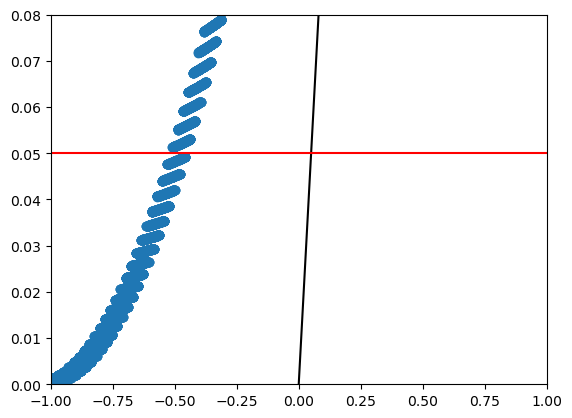

In [70]:
plt.scatter(prediction_modelo, tau_flatten)
plt.plot(np.linspace(-1,6), np.linspace(-1,6), 'k')
plt.hlines(y = 0.05, xmin=-1, xmax=5, color='r')
plt.xlim([-1,1])
plt.ylim([0,0.08])

In [ ]:
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_4_days_5_hourly_particles_20220101_1n_20220105_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_7_days_15_hourly_particles_20220101_1n_20220108_1n.zarr'
ds = xr.open_zarr(file_name, decode_times=True)


In [ ]:
ds.initialized[0,:].values

In [ ]:
days_release = 1
n_release = 5
v_len = 24*days_release
matriz_horas = np.arange(0,v_len)

In [ ]:
idx = np.arange(n_release, n_release*v_len +1, n_release)

In [ ]:
N_obs = v_len
ds_subset = ds.isel(obs=slice(0, N_obs))
# mask
traj = np.arange(len(ds.trajectory))[:, None]
mask = traj >= idx
#
ds_subset = ds_subset.where(~mask)
data_analysis = xr.concat([ds_subset, ds.isel(obs=slice(N_obs, -1))], dim="obs")

In [ ]:
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times

In [ ]:
file_save = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_7_days_15_hourly_particles_20220101_1n_20220108_1n.zarr'
data_analysis.to_zarr(file_save, mode = 'w')

In [ ]:
xr.open_dataset(file_save)

In [ ]:
data = data_analysis
#
colloidal = []
marine = []
bottom = []
sewage = []
total = []
#
for i in range(len(data.obs)):
    len_1 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 1.))[0])
    len_2 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 2.))[0])
    len_3 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 3.))[0])
    len_4 = len(np.where(np.isfinite(data.status[:, i]) & (data.status[:, i] == 4.))[0])
    #
    len_T = np.count_nonzero(~np.isnan(data.status[:, i]))
    #
    sewage.append(len_1)
    colloidal.append(len_2)
    marine.append(len_3)
    bottom.append(len_4)
    total.append(len_T)
#    
proportion_colloidal = np.array(colloidal)/np.array(total)
proportion_marine = np.array(marine)/np.array(total)
proportion_bottom = np.array(bottom)/np.array(total)
proportion_sewage = np.array(sewage)/np.array(total)
#

In [ ]:
plt.plot(proportion_sewage*100, 'b', label = 'S. Particle (SP)', linewidth = 2)
plt.plot(proportion_colloidal*100, 'r', label = 'Colloidal (C)', linewidth = 2)
plt.plot(proportion_marine*100, 'g', label = 'M. Particle (MP)', linewidth = 2)
plt.plot(proportion_bottom*100, 'k', label = 'At Bottom (B)', linewidth = 2)
#ax4.set_xlabel('Time (through simulation)', fontsize=20)
plt.grid(linestyle = '--', alpha = 0.5, linewidth = 2)
#plt.ylim(0,100)

In [ ]:
limit_begin_end = int(timedelta(days=1).total_seconds()/(60*60))
#
data_analysis = ds.isel(obs=slice(limit_begin_end, -limit_begin_end))
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times
#data = xr.open_zarr('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_9_days_15_hourly_particles_20220101_1n_20220110_1n.zarr')
#depth = data.z/data.fact

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
#
path_months = '/results2/SalishSea/month-avg.202111/'
path_days_h = '/results2/SalishSea/nowcast-green.202111/'

Load the necessary fields

In [3]:
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]

In [4]:
#
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

In [6]:
begin = datetime(2015,8,6)
end = datetime(2015,9,6)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [8]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [9]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [15]:
e3t = xr.open_dataset(files_e3t[0][0])

In [18]:
e3t['sossheig'].max()

<xarray.DataArray 'sossheig' ()> Size: 8B
array(2.87710428)

In [22]:
bat_file['totaldepth'].min()

<xarray.DataArray 'totaldepth' ()> Size: 8B
array(0.)

In [ ]:
e3t[0,:,300,300]

array([ 0.9956051 ,  0.995609  ,  0.99561644,  0.99563104,  0.9956594 ,
        0.9957147 ,  0.9958225 ,  0.9960323 ,  0.99644095,  0.9972369 ,
        0.99878705,  1.0018058 ,  1.0076834 ,  1.0191237 ,  1.0413774 ,
        1.0459756 ,  1.1735643 ,  1.335929  ,  1.6463678 ,  2.2299027 ,
        3.2924857 ,  5.119985  ,  7.974515  , 11.825297  , 16.10792   ,
       19.958702  , 22.813232  , 24.640732  , 25.703316  , 26.28685   ,
       26.597288  , 26.759653  , 26.843817  , 26.887241  , 26.909594  ,
       26.921085  , 26.926989  , 26.930021  , 26.931578  , 26.932377  ],
      dtype=float32)

In [35]:
np.cumsum(e3t[0,:,300,300])

<xarray.DataArray 'e3t' (deptht: 40)> Size: 160B
array([  0.9956051,   1.991214 ,   2.9868305,   3.9824615,   4.978121 ,
         5.9738355,   6.969658 ,   7.96569  ,   8.9621315,   9.959369 ,
        10.958156 ,  11.959961 ,  12.967645 ,  13.986769 ,  15.028146 ,
        16.074121 ,  17.247686 ,  18.583616 ,  20.229984 ,  22.459887 ,
        25.752373 ,  30.872358 ,  38.846874 ,  50.672173 ,  66.78009  ,
        86.73879  , 109.552025 , 134.19275  , 159.89606  , 186.1829   ,
       212.7802   , 239.53986  , 266.38367  , 293.2709   , 320.1805   ,
       347.1016   , 374.0286   , 400.95862  , 427.8902   , 454.82257  ],
      dtype=float32)
Coordinates:
    nav_lat        float32 4B ...
    nav_lon        float32 4B ...
  * deptht         (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered  datetime64[ns] 8B ...
    time_counter   datetime64[ns] 8B 2015-08-06T00:30:00

In [ ]:
math.log(e3t.max()) - math.log(0.07)

In [ ]:
math.log(0.07)

In [ ]:
e3t[0][0].plot()

In [22]:
e3t_min = e3t.min() / 2
e3t_max = e3t.max() / 2

In [23]:
u_vel = xr.open_dataset(files_U[0][0])['vozocrtx']
v_vel = xr.open_dataset(files_V[0][0])['vomecrty']

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

$$\tau = u*^{2} \cdot \rho $$

The min value of e3t will describe a 'shallower' point with high velocities, while the max value of e3t will describe a deeper point further down the water column. So, if we get a sense of what range of Tau and velocities values we can find, we can then get t threshold velocity...avoiding extra calculations and loops within the Resuspension  Kernel

In [24]:
U = np.linspace(0, u_vel.max().values,10000)
V = np.linspace(0, v_vel.max().values,10000)
H_component = (U ** 2 + V ** 2) ** (1/2)

In [25]:
TAU_max = (H_component ** 2) * (0.42 ** 2) * ((np.log(e3t_min.values) - np.log(0.07)) ** (-2)) * 1024
TAU_min = (H_component ** 2) * (0.42 ** 2) * ((np.log(e3t_max.values) - np.log(0.07)) ** (-2)) * 1024

In [26]:
t_threshold = 0.05

In [27]:
idx_min = min(range(len(TAU_min)), key=lambda i: abs(TAU_min[i] - t_threshold))
idx_max = min(range(len(TAU_max)), key=lambda i: abs(TAU_max[i] - t_threshold))

Text(0.5, 0.98, 'Bottom Stress Threshold $\\tau _{threshold}$ = 0.05')

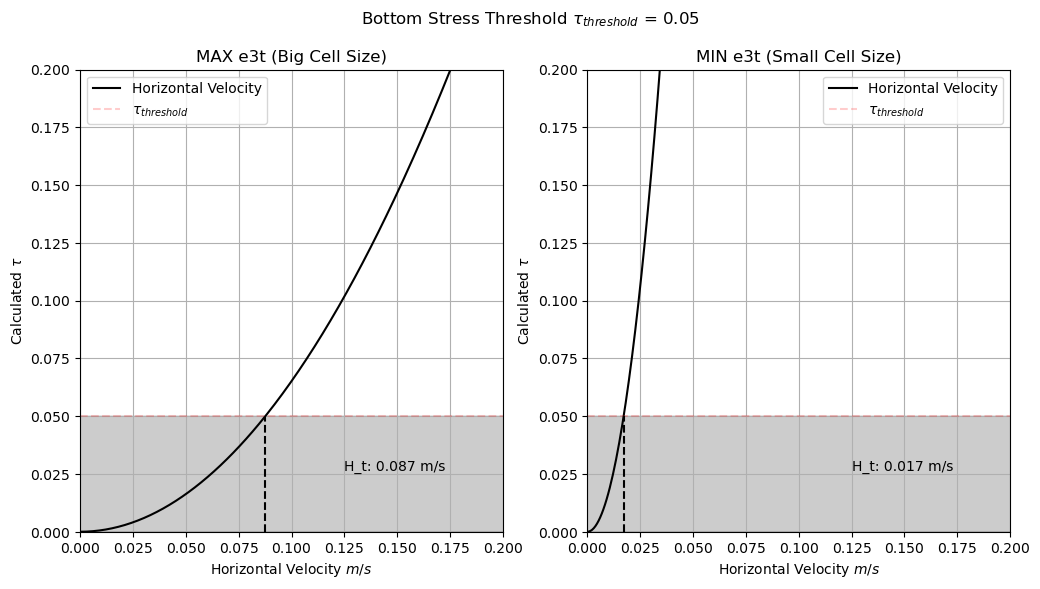

In [28]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].plot(H_component,TAU_min, 'k', label = 'Horizontal Velocity')
ax[0].vlines(x=H_component[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[0].text(0.125, 0.025, f"H_t: {np.round(H_component[idx_min],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[0].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[0].fill_between(x=H_component, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[0].set_ylim([0,t_threshold*4])
ax[0].set_xlim([0,.2])
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r'Calculated $\tau$')
ax[0].set_xlabel(r'Horizontal Velocity $m/s$')
ax[0].set_title('MAX e3t (Big Cell Size)')
#
ax[1].plot(H_component,TAU_max, 'k', label = 'Horizontal Velocity')
ax[1].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[1].vlines(x=H_component[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[1].text(0.125, 0.025, f"H_t: {np.round(H_component[idx_max],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[1].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[1].set_ylim([0,t_threshold*4])
ax[1].set_xlim([0,.2])
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r'Calculated $\tau$')
ax[1].set_xlabel(r'Horizontal Velocity $m/s$')
ax[1].set_title('MIN e3t (Small Cell Size)')
#
plt.suptitle(r'Bottom Stress Threshold $\tau _{threshold}$ = ' + str(t_threshold))

Text(0.5, 0.98, 'Bottom Stress Threshold $\\tau _{threshold}$ = 0.05')

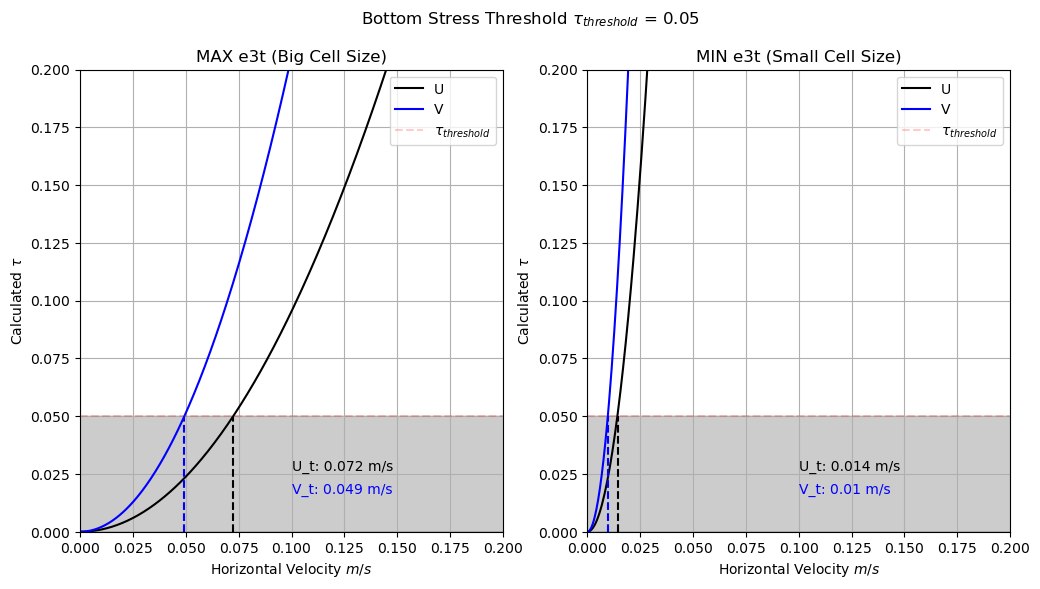

In [29]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].plot(U,TAU_min, 'k', label = 'U')
ax[0].plot(V,TAU_min, 'b', label = 'V')
ax[0].vlines(x=U[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[0].vlines(x=V[idx_min], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'b')
ax[0].text(0.1, 0.025, f"U_t: {np.round(U[idx_min],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[0].text(0.1, 0.015, f"V_t: {np.round(V[idx_min],3)} m/s", color = 'b', fontsize=10, ha='left', va='bottom')
ax[0].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[0].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[0].set_ylim([0,t_threshold*4])
ax[0].set_xlim([0,.2])
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r'Calculated $\tau$')
ax[0].set_xlabel(r'Horizontal Velocity $m/s$')
ax[0].set_title('MAX e3t (Big Cell Size)')
#
ax[1].plot(U,TAU_max, 'k', label = 'U')
ax[1].plot(V,TAU_max, 'b', label = 'V')
ax[1].hlines(y=t_threshold, xmin = 0, xmax = 1, colors = 'r', label=r'$\tau _{threshold}$', linestyle = '--', alpha = .2)
ax[1].vlines(x=U[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'k')
ax[1].vlines(x=V[idx_max], ymin=0, ymax = t_threshold, linestyle = '--', colors = 'b')
ax[1].text(0.1, 0.025, f"U_t: {np.round(U[idx_max],3)} m/s", color = 'k', fontsize=10, ha='left', va='bottom')
ax[1].text(0.1, 0.015, f"V_t: {np.round(V[idx_max],3)} m/s", color = 'b', fontsize=10, ha='left', va='bottom')
ax[1].fill_between(x=U, y1=0, y2=t_threshold, alpha = .2, color = 'k')
ax[1].set_ylim([0,t_threshold*4])
ax[1].set_xlim([0,.2])
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel(r'Calculated $\tau$')
ax[1].set_xlabel(r'Horizontal Velocity $m/s$')
ax[1].set_title('MIN e3t (Small Cell Size)')
#
plt.suptitle(r'Bottom Stress Threshold $\tau _{threshold}$ = ' + str(t_threshold))

Velocity values below these ones for the min and max e3t, will NOT resuspend. But, values above these ones for the min and max e3t, will resuspend :D